This notebook

In [45]:
import os
import sys


D:\innopolis\PMLDL\text-detoxification\models


In [46]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [49]:
import torch
from transformers import BertTokenizer, BertForMaskedLM
import numpy as np


In [50]:
device = torch.device('cpu')

### Load the model

In [51]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [62]:
model = BertForMaskedLM.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [63]:
model.to(device);

#### Load vocabularies for spans detection

In [53]:
vocab_root = '../data/interm/vocab/'

In [54]:
with open(vocab_root + "negative-words.txt", "r") as f:
    s = f.readlines()
negative_words = list(map(lambda x: x[:-1], s))
with open(vocab_root + "toxic_words.txt", "r") as f:
    ss = f.readlines()
negative_words += list(map(lambda x: x[:-1], ss))

with open(vocab_root + "positive-words.txt", "r") as f:
    s = f.readlines()
positive_words = list(map(lambda x: x[:-1], s))

In [55]:
import pickle
with open(vocab_root + 'word2coef.pkl', 'rb') as f:
    word2coef = pickle.load(f)

In [56]:
token_toxicities = []
with open(vocab_root + 'token_toxicities.txt', 'r') as f:
    for line in f.readlines():
        token_toxicities.append(float(line))
token_toxicities = np.array(token_toxicities)
token_toxicities = np.maximum(0, np.log(1/(1/token_toxicities-1)))   # log odds ratio

# discourage meaningless tokens
for tok in ['.', ',', '-']:
    token_toxicities[tokenizer.encode(tok)][1] = 3

for tok in ['you']:
    token_toxicities[tokenizer.encode(tok)][1] = 0

### Applying the model

In [64]:
from models.condbert import CondBertRewriter

editor = CondBertRewriter(
    model=model,
    tokenizer=tokenizer,
    device=device,
    neg_words=negative_words,
    pos_words=positive_words,
    word2coef=word2coef,
    token_toxicities=token_toxicities,
)

In [65]:
print(editor.translate('You are an idiot!', prnt=False))

you are an the !


In [166]:
import pandas as pd
filtered_df = pd.read_csv("../data/interm/test.csv", index_col=None)


In [167]:
def translate_reference(row):
    return editor.translate(row, prnt=False)

In [168]:

filtered_df['translate'] = filtered_df['reference'].apply(translate_reference)

In [169]:
filtered_df.head(20)

,reference,ref_tox,translate
0,"They're all laughing at us, so we'll kick your...",0.999492,"they ' re all laughing at us , so we ' ll kick..."
1,"Come on, Cal, leave that shit alone.",0.999637,"come on , cal , leave that stuff alone ."
2,I like that shit.,0.999594,i like that stuff .
3,How is this not porn? This is porn that comes ...,0.933948,how is this not pornography ? this is pornogra...
4,"Now, I understand you got your grievances with...",0.999603,"now , i understand you got your side of issues..."
5,"I'll rot in front of his cameras, on him.",0.987824,"i ' ll be in front of his cameras , on him ."
6,"Tell him if Elena doesn't pick up the phone, w...",0.995638,tell him if elena doesn ' t pick up the phone ...
7,You wanna know why? if anything happens that's...,0.938261,i know know why ? if anything happens that ' s...
8,You must've been pissed. Damn straight.,0.991549,you must ' ve been there . of straight .
9,The only crime he committed Was standing up to...,0.999450,the only crime he committed was standing up to...


# Reproduction

In [170]:
from tensorflow.keras.models import load_model

model = load_model('model.h5')

In [171]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_test = filtered_df['translate']
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_test_tfidf = tfidf_vectorizer.fit_transform(X_test)


In [172]:
y_pred = model.predict(X_test_tfidf.toarray())

157/157 [==============================] - 1s 3ms/step


In [173]:
filtered_df['tr_tox'] = y_pred

In [174]:
filtered_df['result'] = filtered_df['ref_tox']-filtered_df['tr_tox']

In [105]:
filtered_df['result']

0       0.994501
1       0.001067
2       0.182244
3      -0.028217
4       0.978085
          ...   
4995    0.117209
4996    0.999130
4997    0.650062
4998    0.129239
4999    0.619335
Name: result, Length: 5000, dtype: float64

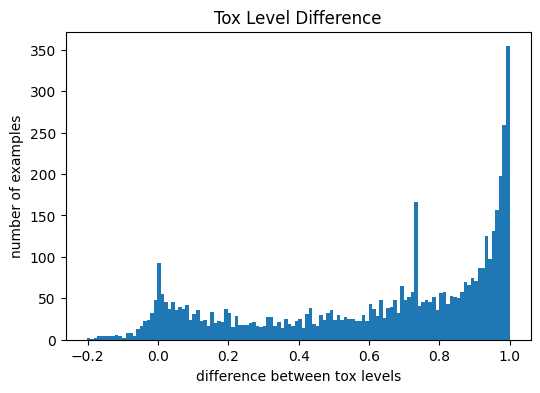

In [106]:
import matplotlib.pyplot as plt

result = filtered_df['result'].tolist()

n_bins=120
plt.figure(figsize=(6, 4))  # Создаем первый график
plt.ylabel('number of examples')
plt.xlabel('difference between tox levels')
plt.hist(result, bins=n_bins)
plt.title('Tox Level Difference')
plt.show()

In [176]:
filtered_df.to_csv('../data/interm/predictBERT.csv')